<a href="https://colab.research.google.com/github/Falconwatch/cybersec_ht/blob/main/Statistical_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q Levenshtein
!pip install -q fuzzywuzzy
!pip install -q python-Levenshtein

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import gc

In [2]:
cust_1 = pd.read_excel("cust_1.xlsx")
cust_2 = pd.read_excel("cust_2.xlsx")
examples = pd.read_excel("examples.xlsx")

In [3]:
cust_1 = cust_1.rename({"c1.country_code":"country_code"}, axis=1)
cust_2 = cust_2.rename({"c2.country_code":"country_code"}, axis=1)

In [4]:
countries = cust_1["country_code"].unique()

# Соберу все возможные комбинации

## Неопределённые данные

In [5]:
country_datas = list()
for country in countries:
  c1 = cust_1[cust_1["country_code"] == country]
  c2 = cust_2[cust_2["country_code"] == country]
  total = c1.reset_index(drop=True).merge(c2.reset_index(drop=True),
                                          on =["country_code"])
  country_datas.append(total)
all_data = pd.concat(country_datas)
all_data["match"] = None
all_data["dataset"] = "data"
all_data.shape

(5073577, 15)

## Разметка мэтчей

In [6]:
def renamer(x):
  if x[-2:]=="_x":
    return x[:-2]
  if x[-2:]=="_y":
    return "c2"+x[2:-2]
  return x

def renamer2(x):
  if x[-2:]=="_x":
    return "c1"+x[2:-2]
  if x[-2:]=="_y":
    return x[:-2]
  return x

In [7]:
wrong_country_datas = list()
for country in countries:
  c1 = cust_1[cust_1["country_code"] == country]
  c2 = cust_2[cust_2["country_code"] == country]
  total1 = c1.reset_index(drop=True).merge(c1.reset_index(drop=True),
                                          on =["country_code"])
  total1.columns = [renamer(c) for c in total1.columns]
  
  total2 = c2.reset_index(drop=True).merge(c2.reset_index(drop=True),
                                          on =["country_code"])
  total2.columns = [renamer2(c) for c in total2.columns]
  
  total1["match"] = 1
  total1.loc[total1["c1.key"]!=total1["c2.key"], "match"] = 0
  total2["match"] = 1
  total2.loc[total2["c1.key"]!=total2["c2.key"], "match"] = 0

  wrong_country_datas.append(total1)
  wrong_country_datas.append(total2)

wrong_data = pd.concat(wrong_country_datas,axis=0)
wrong_data["dataset"] = "generated"
wrong_data.shape

(10147154, 15)

## Примеры

In [8]:
examples = examples.rename({"c1.country_code":"country_code"}, axis=1).drop("c2.country_code", axis=1)
examples["match"] = 1
examples["dataset"] = "examples"
examples.shape

(349, 15)

## Полный датасет

In [9]:
data = all_data.sample(50000).reset_index(drop=True)
sim_not_matches = wrong_data.loc[wrong_data["match"]==0].sample(50000).reset_index(drop=True)

In [10]:
gc.collect()

13

In [11]:
full_data = pd.concat([examples, data,sim_not_matches]).reset_index(drop=True)
full_data["match"] = full_data["match"].astype(float)
full_data.groupby("dataset").agg({"match":["mean"], "c1.key":"count"})

,match,c1.key
,mean,count
dataset,,
data,NaN,50000
examples,1.0,349
generated,0.0,50000


# Вычислю фичи сходства
Идеи:
- Улучшить вычисление расстояния для почтового кода - сверять слева направо

In [12]:
from difflib import SequenceMatcher
def similarity_ratio_func(df, field):
  
  def string_similarity(s1,s2):
    #s1 = [c for c in s1 if c not in [",", ";", ".", ""]]
    #return levenshtein_distance(s1,s2)
    #return SequenceMatcher(isjunk = lambda x: x in " ,;./-_", a = str(s1).upper(), b=str(s2).upper()).ratio()
    return fuzz.WRatio(s1, s2)/100

  def postalcode_similarity(s1, s2):
    longest_string = max([len(s1), len(s2)])
    s1 = s1+"0"*(longest_string - len(s1))
    s2 = s2+"0"*(longest_string - len(s2))

    t = [a==b for a,b in zip(s1, s2)][::-1]

    max_possible_similarity = sum([10**i for i in range(longest_string)])
    current_similarity = sum([t[i]*10**i for i in range(len(t))])
    difference = max_possible_similarity - current_similarity
    difference_ratio = difference/max_possible_similarity
    return 1-difference_ratio
  
  def rating_star_diff(s1, s2):
    #r = abs(float(s1), float(s2))
    try:
      r = abs(float(s1)- float(s2))
      return r
    except:
      return None

  def universal_wrapper(x1, x2, func):
    if pd.isna(x1) or pd.isna(x2):
      return None
    x1=str(x1).upper()
    x2=str(x2).upper()
    return func(x1,x2)

  name1 = "c1." + field
  name2 = "c2." + field
  name3 = field + "_similarity"
  
  if "postal_code" in field:
    df[name3] = df[[name1, name2]].apply(lambda x: universal_wrapper(x[name1], x[name2], postalcode_similarity),
                                          axis=1)
  elif "star_rating" in field:
    df[name3] = df[[name1, name2]].apply(lambda x: universal_wrapper(x[name1], x[name2], rating_star_diff),
                                          axis=1)
  else:
    df[name3] = df[[name1, name2]].apply(lambda x: universal_wrapper(x[name1], x[name2], string_similarity),
                                          axis=1)

In [13]:
feature_fields = [c[3:] for c in cust_1.columns[1:] if "country" not in c]

In [14]:
for ff in tqdm(feature_fields):
  similarity_ratio_func(full_data, ff)

100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


In [15]:
features = [c for c in full_data.columns if ("_similarity" in c) and ("_normed" not in c)]
ids = ["c1.key", "c2.key"]
features+ids

['hotel_name_similarity',
 'city_name_similarity',
 'hotel_address_similarity',
 'star_rating_similarity',
 'postal_code_similarity',
 'c1.key',
 'c2.key']

# Статистический подход

In [16]:
#Для дальнейшей нормализации
means = full_data.loc[full_data["dataset"]=="examples", features].mean()
stds = full_data.loc[full_data["dataset"]=="examples", features].std()

In [17]:
stds

hotel_name_similarity       0.086189
city_name_similarity        0.306524
hotel_address_similarity    0.129651
star_rating_similarity      0.934532
postal_code_similarity      0.098345
dtype: float64

In [18]:
means

hotel_name_similarity       0.944842
city_name_similarity        0.786246
hotel_address_similarity    0.884183
star_rating_similarity      0.561605
postal_code_similarity      0.988271
dtype: float64

In [19]:
#нормализуем
for f in features:
  full_data[f+"_normed"] = (full_data[f]-means[f])/stds[f]

In [20]:
features

['hotel_name_similarity',
 'city_name_similarity',
 'hotel_address_similarity',
 'star_rating_similarity',
 'postal_code_similarity']

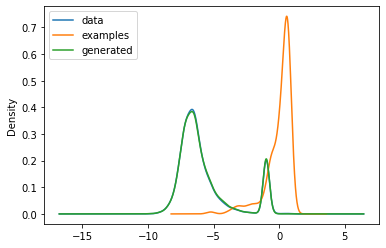

In [21]:
full_data.groupby('dataset')['hotel_name_similarity_normed'].plot(kind='kde')
plt.legend()

dataset
data         AxesSubplot(0.125,0.125;0.775x0.755)
examples     AxesSubplot(0.125,0.125;0.775x0.755)
generated    AxesSubplot(0.125,0.125;0.775x0.755)
Name: city_name_similarity_normed, dtype: object

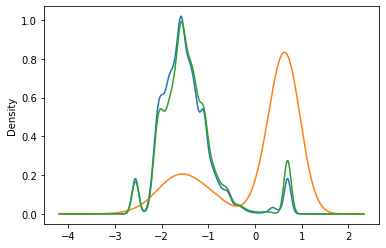

In [22]:
full_data.groupby('dataset')['city_name_similarity_normed'].plot(kind='kde')

dataset
data         AxesSubplot(0.125,0.125;0.775x0.755)
examples     AxesSubplot(0.125,0.125;0.775x0.755)
generated    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hotel_address_similarity_normed, dtype: object

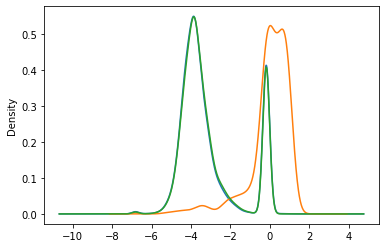

In [23]:
full_data.groupby('dataset')['hotel_address_similarity_normed'].plot(kind='kde')

dataset
data         AxesSubplot(0.125,0.125;0.775x0.755)
examples     AxesSubplot(0.125,0.125;0.775x0.755)
generated    AxesSubplot(0.125,0.125;0.775x0.755)
Name: star_rating_similarity_normed, dtype: object

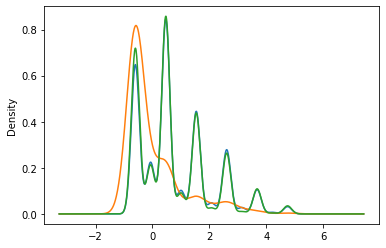

In [24]:
full_data.groupby('dataset')['star_rating_similarity_normed'].plot(kind='kde')

dataset
data         AxesSubplot(0.125,0.125;0.775x0.755)
examples     AxesSubplot(0.125,0.125;0.775x0.755)
generated    AxesSubplot(0.125,0.125;0.775x0.755)
Name: postal_code_similarity_normed, dtype: object

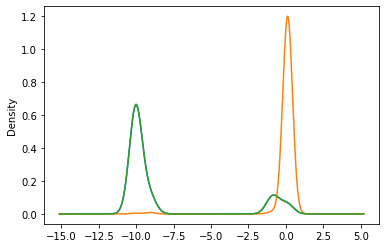

In [25]:
full_data.groupby('dataset')['postal_code_similarity_normed'].plot(kind='kde')

#Квантили распределений

In [26]:
from scipy import stats

In [28]:
examples_tmp = full_data.loc[full_data["dataset"]=='examples']
for f in tqdm(features):
  full_data[f+"_normed_percentilte"] =\
    full_data[f+"_normed"].apply(lambda x: stats.percentileofscore(examples_tmp[f+"_normed"], x)/100)

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


In [29]:
#full_data.sample(10000).to_excel("full_data_sample.xlsx")

## Порог принятия/отвержения гипотезы
Попробуем подобрать порог при котормо следует отвергать ил ипринимать ту ил иную гипотезу - на основе данных из примеров

In [30]:
def perc_research(field):
  rej_perc = list()
  for p in range(0,100,1):
    rejected = full_data.loc[full_data["dataset"]=="examples", field]<p/100
    rejected_mean = rejected.mean()
    rej_perc.append(rejected_mean)
  
  plt.plot(rej_perc, label = field)
  plt.legend()

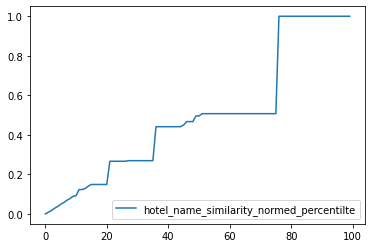

In [31]:
perc_research("hotel_name_similarity_normed_percentilte")

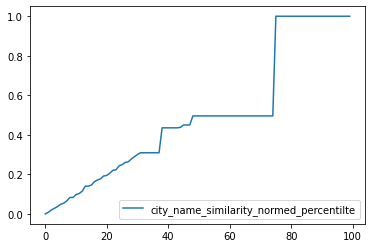

In [32]:
perc_research("city_name_similarity_normed_percentilte")

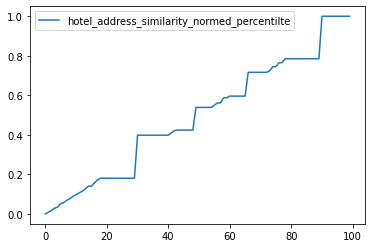

In [33]:
perc_research("hotel_address_similarity_normed_percentilte")

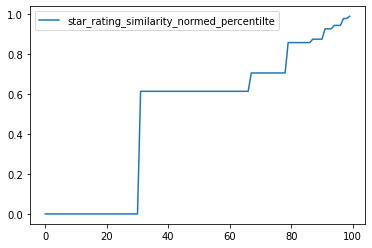

In [34]:
perc_research("star_rating_similarity_normed_percentilte")

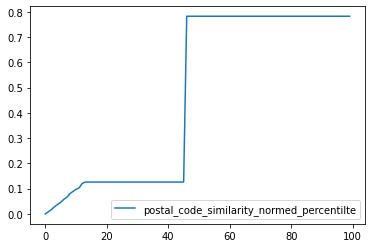

In [35]:
perc_research("postal_code_similarity_normed_percentilte")

## Проверим гипотезы
Множественная проверка from statsmodels.stats.multitest import multipletests показала тебя плохо

In [36]:
percentiles_fields = [c for c in full_data.columns if "_normed_percentilte" in c]
percentiles_fields

['hotel_name_similarity_normed_percentilte',
 'city_name_similarity_normed_percentilte',
 'hotel_address_similarity_normed_percentilte',
 'star_rating_similarity_normed_percentilte',
 'postal_code_similarity_normed_percentilte']

In [37]:
#выберу такой порог отсечнеия чтобы максимально отвести примеры от всех данных
data_rejected = list()
ex_rejected = list()
for pcrit in tqdm(range(0,100,1)):
  rejection = list()
  for f in percentiles_fields:
    name = f[:-30]+"_reject"
    rejection.append(name)
    full_data[name] = full_data[f].apply(lambda x: int(x<pcrit/100))

  full_data["total_rejects"] = full_data[rejection].sum(axis=1)
  
  stats = full_data.groupby("dataset")["total_rejects"].mean()
  data_rejected.append(stats["data"])
  ex_rejected.append(stats["examples"])

  #print(pcrit/100)

100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


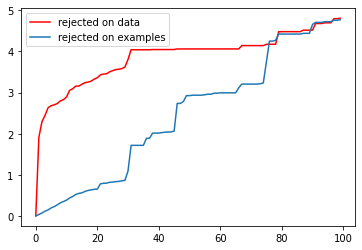

In [38]:
import matplotlib.pyplot as plt
plt.plot(data_rejected, label = "rejected on data", color="red")
plt.plot(ex_rejected, label = "rejected on examples")
plt.legend()

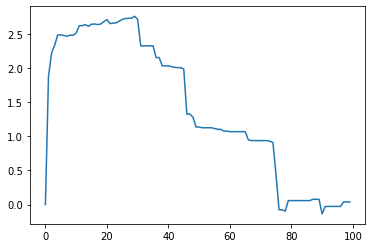

In [39]:
plt.plot([d-e for d,e in zip(data_rejected,ex_rejected)])

In [40]:
rejection = list()
for f in percentiles_fields:
  name = f[:-30]+"_reject"
  rejection.append(name)
  full_data[name] = full_data[f].apply(lambda x: int(x<0.3))

full_data["total_rejects"] = full_data[rejection].sum(axis=1)

In [41]:
#full_data[rejection+["total_rejects"]]

In [42]:
#full_data.to_excel("full_data.xlsx")

## Анализ результатов на основе гипотез


In [91]:
full_data.groupby("dataset")["total_rejects"].mean()

dataset
data         3.806340
examples     1.094556
generated    3.808040
Name: total_rejects, dtype: float64

In [92]:
bad_examples = full_data[full_data["total_rejects"]>2]
good_examples = full_data[full_data["total_rejects"]<2]

In [93]:
good_examples.groupby("dataset")["match"].mean()

dataset
data         NaN
examples     1.0
generated    0.0
Name: match, dtype: float64

In [94]:
bad_examples.groupby("dataset")["match"].mean()

dataset
data         NaN
examples     1.0
generated    0.0
Name: match, dtype: float64

In [96]:
bad_examples["match"].mean()
good_examples["match"].mean()

0.9607843137254902

In [47]:
good_examples.loc[good_examples["dataset"]=="data"].to_excel("good_examples.xlsx")

# ML

In [79]:
ml_features = [
       #'hotel_name_similarity','city_name_similarity', 'hotel_address_similarity',
       #'star_rating_similarity', 'postal_code_similarity',
       'hotel_name_similarity_normed', 'city_name_similarity_normed',
       'hotel_address_similarity_normed', 'star_rating_similarity_normed',
       'postal_code_similarity_normed',
       #'hotel_name_similarity_normed_percentilte',
       #'city_name_similarity_normed_percentilte',
       #'hotel_address_similarity_normed_percentilte',
       #'star_rating_similarity_normed_percentilte',
       #'postal_code_similarity_normed_percentilte', 
       #'hotel_name_reject',
       #'city_name_reject', 'hotel_address_reject', 'star_rating_reject',
       #'postal_code_reject', 'total_rejects'
       ]

In [80]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [81]:
full_data["match"] = full_data["match"].astype(float)
train, test = train_test_split(full_data.loc[pd.notna(full_data["match"])])

In [83]:
clf = LGBMClassifier()

In [84]:
clf_fitted = clf.fit(train[ml_features], train["match"])
[(f,i) for f,i in zip(ml_features, clf_fitted.feature_importances_)]

[('hotel_name_similarity_normed', 788),
 ('city_name_similarity_normed', 655),
 ('hotel_address_similarity_normed', 510),
 ('star_rating_similarity_normed', 443),
 ('postal_code_similarity_normed', 604)]

In [85]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test["match"], clf_fitted.predict_proba(test[ml_features])[:,1])

0.9998785865100729

In [86]:
roc_auc_score(train["match"], clf_fitted.predict_proba(train[ml_features])[:,1])

0.9999999004789352

## Применим на всех данных

In [87]:
full_data["ml_predicted"] = clf_fitted.predict(full_data[ml_features])
full_data["ml_predicted_proba"] = clf_fitted.predict_proba(full_data[ml_features])[:,1]

In [105]:
full_data.loc[(full_data["dataset"]=="examples")&(full_data["ml_predicted"]==0), full_data.columns[:15]]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,match,dataset
1,5BB207CBB33F3D099BCD979F86B3F54B,Chongqing Yangtze River Internatioanl Youth Ho...,Chongqing,CN,"No. 80, Changbin Road, Chao Tian Men Port",3.0,400010,9288C09CFB7714C3CAF57723C04BB6A4,Yangtze River International Youth Hostel,Chongqing,"No 80,Changbin Rd,Dock 11,ChaoTianMen,Yuzhong ...",2.0,400010,1.0,examples
83,D0E7E132418B732F717D4348FEE17AE1,Tulips Hotel & Restaurant,Yogyakarta,ID,Jalan Tirtodipuran 42 Yogyakarta,1.0,55143,89EAD862FE8A80C066D5DD550FFDE2F5,Hotel Tulips,Yogyakarta,Jl. Tirtodipuran 42,2.0,55143,1.0,examples
196,73D429BC62EFC7149CFB36C6800C289E,Even Suites by Spree,Hampi,IN,Bus Stand Road,3.0,583201,D564A93B1225C95D7FB0C588DD609EB8,Even Suites - Managed by Spree,Hospet,"343, 4th ward, opp SBI Bank, Hospet India",3.0,583201,1.0,examples
287,DFC0A6F87D87F4EE1E7AB36B1C605DA2,Bakeroom1 Hostel,Chiang Mai,TH,10/17 NimmanHaemin Road Lane 17,2.0,50100,E06B2BE5AFB60DBF5999749F5D79E64C,Bake Room,Chiang Mai,"10/17, Nimmana Haeminda Rd Lane 17, Amphoe Mue...",0.0,50220,1.0,examples
288,85F1C44C25A14B5E918B6D2917FEF5E2,7 Days Inn Guangzhou Baiyun Yongtai Metro 2nd ...,Guangzhou,CN,"Building 3, No. 116 Tongtai Road",1.5,NaN,739B4F2C65D4DBCE62C30CE8C18FCBFF,7Days Inn Guangzhou Baiyun Yongtai Subway Stat...,Guangzhou,"No. 3 Building, No. 116 Tongtai Road, Baiyun D...",2.0,510420,1.0,examples
